# Assignment 3: Preprocessing

Authors:
- Robbert van der Mijn, w.r.van.der.mijn@rug.nl, 2022
- Mark Span, m.m.span@rug.nl, 2022-2025
- Olaf Dimigen, olaf.dimigen@rug.nl, 2024-2025

This assignment will take you through some of the required steps for preprocessing your own data later on.

Here, we'll use the data we collected during the demonstration experiment (hint: open up the experiment once more to check out the durations of all the phases)

You'll to this assignment individually on you own computer (or one of the university computers).

You are likely to run into many errors. THIS IS NORMAL. A big part of scientific computing is solving problems. Sometimes, when you enter one of your error messages into google, you will not get a solution to your problem. Ask us for help early! Asking the correct question is hard!

You can sequentially run the chunks of code in this script and they will gradually take you through the preprocessing of our demo data. Sometimes you are asked to fill in some code (it will be marked with #TODO) and sometimes you are asked to interpret output using text.

We use some utilities to  our analysis. In python, these are called ```libraries``` or ```modules```. Some of these modules are not installed by default with Python in your computer, install them first. This syntax will (try to) do so if needed. There is no need for you to understand how this works (yet..).

In [25]:
# This cell checks if the required Python libraries are installed and installs them if they are not.
# Libraries like 'gdown', 'eyelinkparser', and 'time_series_test' are essential for downloading
# data, parsing eye-tracking data, and performing time-series analysis, respectively.
# The `try...except ImportError` block is a standard Python way to handle potential errors
# that occur when trying to import a module. If the module is not found, the code in the
# `except` block is executed, which in this case uses the `!pip install` command
# to install the missing library.
# The `--no-warn-script-location` flag is used to suppress warnings about the installation location.
try:
    import gdown
    print("GDOWN was already installed: Good")
except ImportError:
    print("Installing GDOWN")
    !pip install --no-warn-script-location gdown
try:
    import eyelinkparser
    print("Eyelinkparser was already installed: Good")
except ImportError:
    print("Installing eyelinkparser")
    !pip install eyelinkparser
try:
    import time_series_test as tst
    print("Time_series_test was already installed: Good")
except ImportError:
    !pip install time_series_test

GDOWN was already installed: Good
Eyelinkparser was already installed: Good
Time_series_test was already installed: Good


Check that the versions of eyelinkparser and datamatrix are 0.17.5 and 1.0.16 (or later)


# Getting the data

The cell below will download the data from some subjects performing the experiment I showed you the first meeting: the task that compares the simple and hard calculations.
The data is downloaded from a Google Drive, hence the name "gdown"!

In [2]:
import gdown
import os

# check if we have allready done this: only download the data if they are not alleady there
# Define the expected file path for one of the downloaded files.
file_path = "data/sub_1.asc"
# Use os.path.exists() to check if the file already exists.
if os.path.exists(file_path):
    # If the file exists, print a message indicating that the files were already downloaded.
    print("Files allready downloaded")
else:
    # If the file does not exist, define the Google Drive URL for the data folder.
    url = r'https://drive.google.com/drive/folders/1aJSK0F6vaN-scfkr1xExg3x_FRK8Gd9B'
    # Use gdown.download_folder() to download the entire folder from the URL.
    gdown.download_folder(url)

Files allready downloaded


It is common to start your analysis script with loading modules you will use later on.


In [3]:
# Import necessary libraries for data analysis and visualization.
from datamatrix import (
    plot, # For plotting data.
    operations as ops, # Provides various operations on datamatrix objects.
    series as srs, # Contains functions for working with SeriesColumns (time series data).
    functional as fnc, # Provides functional programming tools, like memoization.
    SeriesColumn, # Represents a column containing time series data.
)
from eyelinkparser import parse, defaulttraceprocessor # For parsing and processing eye-tracking data from EyeLink files.
import numpy as np # Fundamental library for numerical operations, often used for array manipulation.
from matplotlib import pyplot as plt # For creating static, interactive, and animated visualizations.
import matplotlib.font_manager # For managing fonts in Matplotlib plots.



The following lines define our own custom function that we can use to get our data from the folder called ```/data```. It wraps around the ```parse``` function which comes with ```eyelinkparser``` and returns its result. The first time you run it, it will take some time. The ```memoize``` _decorator_ makes sure that the result is stored on your computer, so it will be much faster the second time.

In [4]:
# Define a filter function to specify which trial phases to include.
# This function will be called by eyelinkparser for each phase found in the data.
def filt(name):
  # Only include the phase named "trial".
  if name == "trial":
    return True
  # Exclude all other phases.
  return False

# Define a function to get the data.
# The @fnc.memoize(persistent=True) decorator caches the result of this function.
# The first time it runs, it will parse the data. Subsequent calls will return the cached result quickly.
# persistent=True means the cache is saved to disk and persists between sessions.
@fnc.memoize(persistent=True)
def get_data():
    # Use the parse function from eyelinkparser to read and process the eye-tracking data.
    dm = parse(
        # Configure the trace processor.
        traceprocessor = defaulttraceprocessor(
          blinkreconstruct = False, # Disable automatic blink reconstruction during parsing.
          downsample = None, # Do not downsample the data.
          mode = 'advanced' # Use advanced mode for trace processing.
        ),
        phasefilter = filt, # Apply the custom filter function to select phases.
        trialphase = "trial" # Specify the name of the trial phase to process.
    )
    return dm

# get_data.clear() # Uncomment this line to clear the cached data and re-parse the files.
# Call the get_data function to load the data into the datamatrix variable 'dm'.
dm = get_data()

Great! We have now a datamatrix containing the data of all participants.

Let's inspect the information we have in our data table. Can you think of some useful statements to inspect what variables there are in a data table. hint: check out the cheat sheet on https://datamatrix.cogsci.nl/ and http://pydatamatrix.eu/1.0/eyelinkparser/

ASSIGNMENT:
- Print all the column names to the console
- Print out the the colums named ```subject_nr``` and ```ptrace_fixation```

In [5]:
# TODO
print(dm.subject_nr)
print(dm.ptrace_trial)


col[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41]
col[[1523. 1522. 1522. ...   nan   nan   nan]
 [1694. 1690. 1689. ...   nan   nan   nan]
 [1455. 1459. 1463. ...   nan   nan   nan]
 ...
 [ 746.  750.  753. ...   nan   nan   nan]
 [ 877.  878.  877. ...   nan   nan   nan]
 [ 845.  846.  850. ...  

Those are quite some columns! A few of these columns are not very interesting to us, so we'll get rid of them momentarily.

Each row in this table contains the information about a single trial. In this demo, each participant did 44 trials.

ASSIGNMENT:
- Confirm this by printing the number of rows in this table, and the number of (unique) subjects

In [6]:
# TODO
print(len(dm))
print(np.unique(dm.subject_nr))

220
[ 1  2  3 31 41]


When you printed the whole column "subject_nr", it listed for each trial to which participant that trial belongs. During each trial, we've been sending messages at the start and end of phases.

ASSIGNMENT:
- List the phases here in the correct order
- Create a new version of dm, having only the relevant columns
  - subject_nr
  - count_trial_sequence
  - difficulty
  - and the relevant traces for all the phases (ptrace_"phasename")

In [7]:
# TODO
dm = dm[dm.subject_nr, dm.count_trial_sequence, dm.difficulty, dm.ptrace_trial]

The continuous data of each phase (e.g., pupil size, gaze coordinates) are stored as ```SeriesColumns```. For example, each cell of the column ```ptrace_response``` contains a collection of pupil sizes for that particular trial, in the response phase.

Most phases are always exactly the same duration in each trial (the "problem" phase is always exactly 800ms). But, some phases have variable duration ("response" just ends when the pp presses a button). However, any ```SeriesColumn``` must always be a particular "depth" (think of our table as a "3d" table; a matrix). Its depth will always be the same depth as the longest trial, but the values will be padded with a special type of data: ```nan``` ("not a number"). Those appear as holes in your plot. The moments the eyetracker could not measure the size of the pupil are also marked by these ```nan``` values.


In [8]:
dm.pupil = dm.ptrace_trial


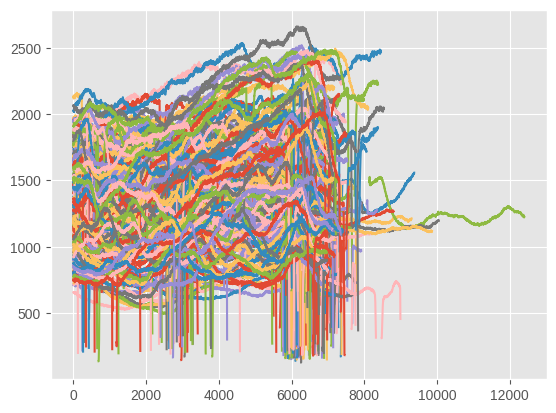

In [9]:
for pupil in dm.pupil:
    plt.plot(pupil)

## Look at the data!

This plot visualizes the raw pupil size trace for each trial in the dataset.
Each colored line represents the pupil size over time for a single trial.
The x-axis represents time (in samples, starting from 0).
The y-axis represents the raw pupil size (in arbitrary units measured by the eye tracker).
Key features to observe:
- The vertical lines represent periods of missing data, often due to blinks. The eye tracker cannot measure pupil size during a blink.
- The right side of the plot shows that trials have different durations, resulting in the lines ending at different points. The `nan` values we saw earlier in the `ptrace_trial` column are responsible for the gaps and variable lengths at the end of the traces.
- You can also see variability in the overall pupil size and fluctuations within trials, which is expected.

This plot highlights the presence of missing data (blinks) and variable trial lengths, which are common issues in eye-tracking data and need to be addressed during preprocessing.

### Important
This might be the most important part of the Assignment: look at the plot you just made. Try to understand what you are looking at, and why it looks this way: what are those weird vertical lines, and what is happening on the right side of the plot?

When analyzing your own data, this is even more relevant. Don't (ever) just pull your data through a script. Look and try to understand, and ask if you don't.


# Blink reconstruction

When a participant blinks, data recorded during that period is missing or distorted.

We use srs.blinkreconstruct to create a new trace in which these are restored.

For now, we'll call the column ```pupil_reconstructed```. In practice, you would overwrite the original one, or use a more practical (i.e., short) name.


In [10]:
dm.pupil_reconstructed = srs.blinkreconstruct(dm.pupil, mode = "advanced")

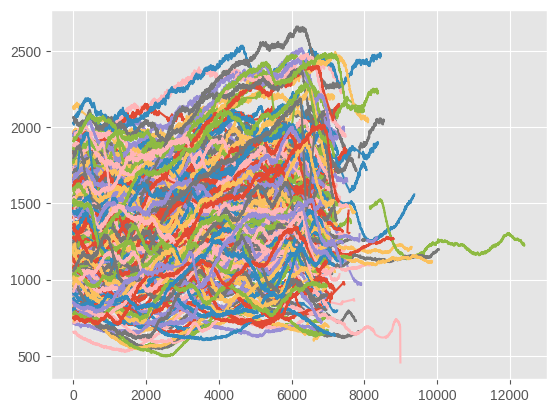

In [11]:
for pupil in dm.pupil_reconstructed:
    plt.plot(pupil)

This plot shows the pupil size traces after applying blink reconstruction.
Similar to the previous plot, each colored line represents a single trial, with time on the x-axis and pupil size on the y-axis. Compared to the raw pupil data plot, you should observe that the vertical gaps caused by blinks are now filled in. The `srs.blinkreconstruct` function has estimated the pupil size during these periods of missing data. The overall shape and trend of the pupil size within each trial are preserved, but the discontinuous drops to zero or near-zero during blinks have been replaced with interpolated values.This plot demonstrates the effect of the blink reconstruction step and allows you to visually assess if the interpolation appears reasonable. Note that the variable trial lengths at the end of the traces are still present.

Let's visualize how that reconstruction works.

We can plot the two traces simultaneously. We'll color the original one red (```alpha = .5``` will also make it a bit "see-through"). In most trials, the participant will not have blinked. Now see if the blinks were interpolated correctly.

Text(0.5, 1.0, '1')

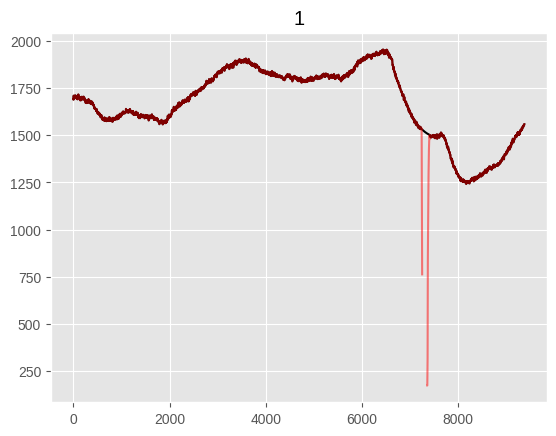

In [12]:
row_nr = 1
plt.figure()
plt.plot(dm.pupil_reconstructed[row_nr], color = "black")
plt.plot(dm.pupil[row_nr], color = "red", alpha = .5)
plt.title(row_nr)

This plot provides a close-up view of a single trial (in this case, trial number 1, as indicated by the title) to illustrate the effect of blink reconstruction. The black line shows the pupil size trace after blink reconstruction (`dm.pupil_reconstructed[row_nr]`). The red line shows the original raw pupil size trace for the same trial (`dm.pupil[row_nr]`). The `alpha=.5` makes the red line semi-transparent so you can see the black line underneath.

By comparing the two lines, you can clearly see where blinks occurred in the original data (represented by the sharp drops or missing values in the red line) and how the blink reconstruction algorithm has interpolated values to fill these gaps in the black line.
This visualization helps to understand how the blink reconstruction process works and to verify that it is effectively handling missing data due to blinks for a specific trial.

# Baselining

Now we want to analyze the difference between easy and difficult trials. To do that, we first need to put all trials at the same starting point. So we perform baseline correction. As a baseline, we use the last 25 samples of the baseline trace.


In [13]:
dm.pupil_baselined = srs.baseline(
    series=dm.pupil_reconstructed,
    baseline=dm.ptrace_trial,
    bl_start=1500,
    bl_end=1525
)

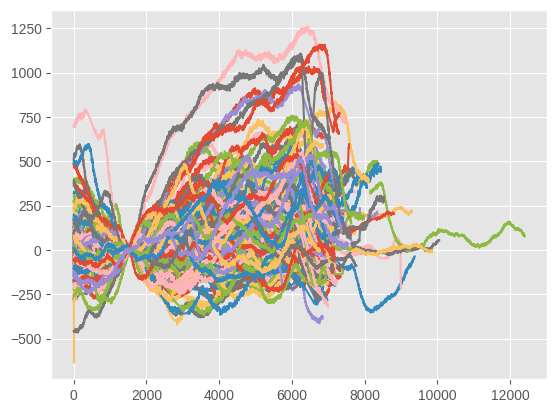

In [14]:
for pupil in dm.pupil_baselined:
    plt.plot(pupil)

This plot displays the pupil size traces after baseline correction. Each colored line represents the baselined pupil size over time for a single trial.

The x-axis is still time (in samples), and the y-axis now represents the change in pupil size relative to the baseline period. The baseline correction step involves subtracting the average pupil size during a specific baseline period (here, the last 25 samples of the baseline trace) from the entire trace for each trial.

As a result, all the traces are centered around zero at the beginning of the trial (specifically, during the baseline period). This makes it easier to compare pupil size changes across trials and participants, as the baseline differences are removed.

You can see that the traces now start near zero and show fluctuations relative to this baseline. The variable trial lengths and the reconstructed blinks are still present.

# Plot the effects.

There are two main types of trials: the easy and the hard trials. Our hypothesis is that there is an effect of this trial type on the size of the pupil. Let's plot the mean pupil sizes per trialtype, with the standard error around it.

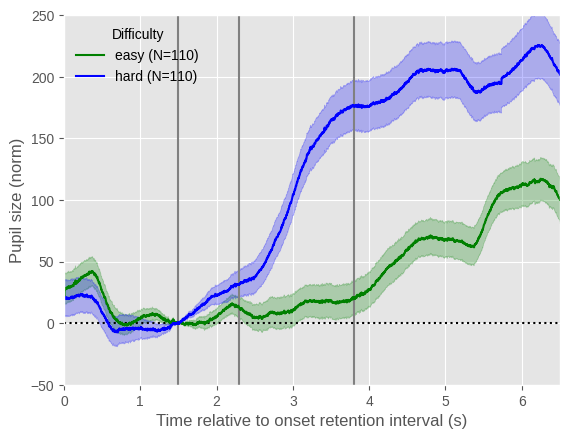

In [42]:
import numpy as np

# define a plot function for a subset of trials:
def plot_series(x, s, color, label):
    # convert the standard deviation to the standard error of the mean
    se = s.std / np.sqrt(len(s))
    # and then plot the lines
    plt.fill_between(x, s.mean-se, s.mean+se, color=color, alpha=.25)
    plt.plot(x, s.mean, color=color, label=label)


x = np.linspace(0, dm.pupil_baselined.depth/1000, dm.pupil_baselined.depth)
easy, hard = ops.split(dm.difficulty, "easy", "hard")

plt.figure()
plt.xlim(0, 6.5)
plt.ylim(-50, 250)

plt.axvline(1.500, linestyle='-', color='grey') # end of the baseline
plt.axvline(2.300, linestyle='-', color='grey') # end of the view of the problem
plt.axvline(3.800, linestyle='-', color='grey') # end of the probem solving stage

plt.axhline(0, linestyle=':', color='black') # plot the line at y=0.

plot_series(x, easy.pupil_baselined, color='green', label='easy (N=%d)' % len(easy))
plot_series(x, hard.pupil_baselined, color='blue', label='hard (N=%d)' % len(hard))

plt.ylabel('Pupil size (norm)')
plt.xlabel('Time relative to onset retention interval (s)')
plt.legend(frameon=False, title='Difficulty')

plt.show()

In the time_series_test package, there is a plot function that is easily used (here to see the individual traces per subject)

/usr/local/lib/python3.12/dist-packages/datamatrix/_datamatrix/_multidimensionalcolumn.py:207: RuntimeWarning: Mean of empty slice
  return nanmean(self._seq, axis=0)
/usr/local/lib/python3.12/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(0.0, 6.5)

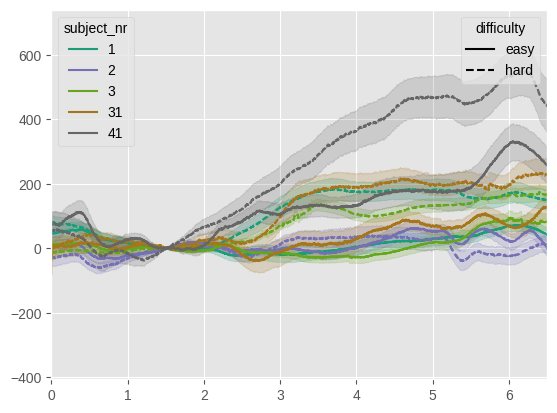

In [31]:
from matplotlib import pyplot as plt

tst.plot(dm, dv='pupil_baselined', hue_factor='subject_nr', linestyle_factor='difficulty',
         sampling_freq=1000)
plt.xlim(0, 6.5)

In [37]:
from statsmodels.formula.api import mixedlm
from datamatrix import series as srs, NAN

dm.mean_pupil_problem  = srs.reduce(dm.pupil_baselined[:, 1500:2300])
dm.mean_pupil_fixation = srs.reduce(dm.pupil_baselined[:, 2300:3800])
dm.mean_pupil_solution = srs.reduce(dm.pupil_baselined[:, 3800:5000])

dm_valid_data = dm
model = mixedlm(formula='mean_pupil_problem ~ difficulty',
                data=dm_valid_data, groups='subject_nr').fit()
print('PROBLEM PHASE')
print(model.summary())
model = mixedlm(formula='mean_pupil_fixation ~ difficulty',
                data=dm_valid_data, groups='subject_nr').fit()
print('FIXATION PHASE')
print(model.summary())
model = mixedlm(formula='mean_pupil_solution ~ difficulty',
                data=dm_valid_data, groups='subject_nr').fit()
print('SOLUTION PHASE')
print(model.summary())


PROBLEM PHASE
             Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mean_pupil_problem
No. Observations: 220     Method:             REML              
No. Groups:       5       Scale:              2580.2568         
Min. group size:  44      Log-Likelihood:     -1172.4501        
Max. group size:  44      Converged:          Yes               
Mean group size:  44.0                                          
----------------------------------------------------------------
                       Coef.  Std.Err.   z   P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept               4.933    6.798 0.726 0.468 -8.391 18.258
difficulty[T.hard]     12.386    6.854 1.807 0.071 -1.047 25.820
subject_nr Var        113.728    2.422                          

FIXATION PHASE
              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mean_pupil_fixation
No. Observations: 220

# Further Resources

Here are some resources to help you further your Python and data analysis skills, especially with the libraries used in this notebook:

### General Python Learning

*   **Official Python Tutorial:** A great starting point for learning the core concepts of Python. [https://docs.python.org/3/tutorial/](https://docs.python.org/3/tutorial/)
*   **Codecademy:** Offers interactive courses on Python fundamentals. [https://www.codecademy.com/learn/learn-python-3](https://www.codecademy.com/learn/learn-python-3)
*   **Coursera / edX:** These platforms offer various Python courses from universities around the world, often covering data science applications. Search for "Python for Data Science".

### Library Specific Resources

*   **datamatrix Documentation:** The official documentation provides detailed information on how to use the `datamatrix` library for data manipulation and analysis. [https://datamatrix.cogsci.nl/](https://datamatrix.cogsci.nl/)
*   **eyelinkparser Documentation:** Learn more about parsing and processing EyeLink eye-tracking data with this library. [http://pydatamatrix.eu/1.0/eyelinkparser/](http://pydatamatrix.eu/1.0/eyelinkparser/)
*   **NumPy Documentation:** The essential guide to numerical computing with Python. [https://numpy.org/doc/stable/](https://numpy.org/doc/stable/)
*   **Matplotlib Documentation:** Learn how to create a wide variety of plots and visualizations. [https://matplotlib.org/stable/contents.html](https://matplotlib.org/stable/contents.html)

These resources will provide you with a deeper understanding of the tools used in this notebook and help you apply them to your own data.